# Forecasting Price and Volatility of Corn Futures Contracts
https://github.com/ledermau/corn-forecasting

Investors, farmers, and consumers would all benefit from accurate prediction of price and volatility of agricultural commodities. In this project I use recent and current weather conditions as the predictive variable in a model of the price of agricultural commodities. To start, I am focusing on corn price, because it one of the largest and most important industrial products produced in the US, with relatively stable demand. Moreover, we are currently in the midst of planting season for corn, when the effects of weather will be most pronounced. See README.md for detailed rationale.


### Data Preprocessing
We will use NOAA data for precipitation in central Iowa, the heart of the corn belt. Corn prices and other financial data will be downloaded from Quandl. We are using data from the Minneapolis Corn Exchange, a major hub for buying and selling corn and other grains grown in the midwest.

#### Load libraries and import data

In [6]:
setwd("c:/Users/Admin/git/corn-futures-forecasting")
source("./auth.R") #loads API keys
source("./functions.R")

library('tseries')
library('forecast')
library('data.table')
library(Quandl)

corn_price.df <- Quandl("TFGRAIN/CORN", api_key=quandlKey)
name = "Corn Spot Price"
#corn_futures.df <- Quandl("BCMGEX/ICH2016", api_key=quandlKey)

wndw <- 30 #number of days to calculate volatility in sliding window
volatility <- sapply(corn_price.df$Date, function(d){
  idx <- findInterval(corn_price.df$Date, c(d-wndw, d)) == 1
  v <- 100 * sd(corn_price.df[["Cash Price"]][idx])/mean(corn_price.df[["Cash Price"]][idx])
  return(v)
})
corn_price.df <- cbind(corn_price.df, volatility)

head(corn_price.df)

Date,Cash Price,Basis,Fall Price,Fall Basis,volatility
2019-04-30,3.39,-0.24,3.52,-0.29,1.024736
2019-04-29,3.36,-0.16,3.52,-0.29,1.043689
2019-04-26,3.35,-0.16,3.52,-0.29,1.498537
2019-04-25,3.32,-0.16,3.48,-0.29,1.658621
2019-04-24,3.31,-0.16,3.47,-0.29,1.823324
2019-04-23,3.31,-0.20,3.51,-0.29,1.727416


#### Clean up the weather data

In [7]:
##################
#get weather data - we will only be using precipitation for now
weather.df <- read.csv("./data/mount-auburn-weather.csv")
weather.df <- weather.df[,c(1:6,11)] #to simplify things visually, remove columns we won't be using (for now)
weather.df$Date <- as.Date(weather.df$DATE, format = "%Y-%m-%d")
weather.df <- weather.df[order(weather.df$Date, decreasing = F),]
weather.df <- weather.df[!is.na(weather.df$Date) & !duplicated(weather.df$Date),]

head(weather.df)

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,Date
2536,USC00130600,"BELLE PLAINE, IA US",41.8814,-92.2764,246.9,2005-01-01,0.0,2005-01-01
2537,USC00130600,"BELLE PLAINE, IA US",41.8814,-92.2764,246.9,2005-01-02,13.0,2005-01-02
2538,USC00130600,"BELLE PLAINE, IA US",41.8814,-92.2764,246.9,2005-01-03,0.0,2005-01-03
2539,USC00130600,"BELLE PLAINE, IA US",41.8814,-92.2764,246.9,2005-01-04,2.0,2005-01-04
2540,USC00130600,"BELLE PLAINE, IA US",41.8814,-92.2764,246.9,2005-01-05,5.6,2005-01-05
2541,USC00130600,"BELLE PLAINE, IA US",41.8814,-92.2764,246.9,2005-01-06,20.8,2005-01-06


#### Engineer some features, and create test and training data sets

In [21]:
wndw <- 45 #window in days to average precipitation over
lag_days <- 60 #lag in days

freq <- 52 #frequency of our time series, we are using 52 for weekly
train_start <- c(2007, 1) #year and month
train_end <- c(2018, 10)
test_start <- train_end #c(2017, 1)
test_end <- c(2019, 4) #ending april, 2019

weather.df$PRCP_lagged <- shift(weather.df$PRCP, n = lag_days, fill = NA, type = 'lag')

weather.df$PRCP_lagged_mean <- sapply(weather.df$Date, function(d){
  idx <- findInterval(weather.df$Date, c(d-wndw, d)) == 1
  p_mean <- mean(weather.df$PRCP_lagged[idx], na.rm = T)
  return(p_mean)
})

weather.df$n_rainyDays <- sapply(weather.df$Date, function(d){
  idx <- findInterval(weather.df$Date, c(d-wndw, d)) == 1
  n_rainy <- sum(weather.df$PRCP_lagged[idx] > 0, na.rm = T)
  return(n_rainy)
})

td = seq(as.Date("2000-12-01"), as.Date("2019-04-30"), "weeks")
cp.z <- zoo(corn_price.df[["Cash Price"]], order.by = td)

#dat.ts is the data we will be modeling. Here we can choose price or volatility, or some other variable.
#Putting our data into a generic variable lets us easily change it later without having to change all the code
dat.ts <- ts(cp.z) #price
#dat.ts <- ts(cv.z) #volatility #for example we could put volatility, or any other time series variable here instead

#xreg.ts will be our exogenous regressor variable in the ARIMA.
prcp_lagged_mean.ts <- ts(zoo(weather.df$PRCP_lagged_mean[!is.na(weather.df$PRCP_lagged_mean)], order.by = td))
n_rainyDays.ts <- ts(zoo(weather.df$n_rainyDays, order.by = td))

#We can choose out lagged mean of precipitation, or number of rainy days, etc
xreg.ts <- prcp_lagged_mean.ts
#xreg.ts <- n_rainyDays.ts

# define the training and test set data
dat_training.ts <- ts(dat.ts, start = train_start, end = train_end, freq = freq)
xreg_training.ts <- ts(xreg.ts, start = train_start, end = train_end, freq = freq)

#create the test set data
dat_test.ts <- ts(dat.ts, start = test_start, end = test_end, freq = freq)
xreg_test.ts <- ts(xreg.ts, start = test_start, end = test_end, freq = freq)

h = length(dat_test.ts)

## Exploratory Analysis
### Plot the data
It looks like there could be some correlation between lagged mean precipitation and corn price.

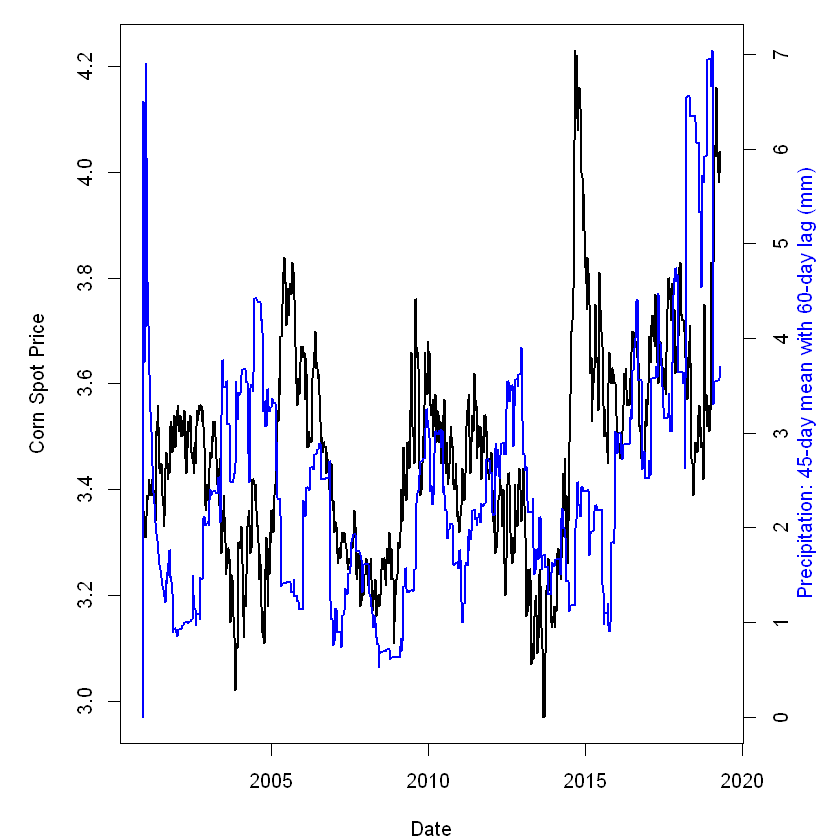

In [22]:
par(mar = c(4,5,1,4))
plot(x = attributes(dat.ts)$index, dat.ts, type = 'l', lwd = 2, ylab = name, xlab = 'Date')
par(new = T)
plot(x = attributes(xreg.ts)$index, y = xreg.ts, xaxt = 'n', yaxt = 'n', type = 'l', lwd = 2, col = "blue", ylab = '', xlab = '')
axis(4); mtext(paste("Precipitation: ", wndw, "-day mean with ", lag_days, "-day lag (mm)", sep = ''), col = 'blue', side = 4, line = 2)


### Test the data for stationarity
The p-value for ADF test is high, the data is not stationary, which we can see in the plot.

Some degree of differencing will be required to make a stationary time series.

In [23]:
Box.test(dat.ts, lag = 1, type = 'Ljung-Box')
adf.test(dat.ts)


	Box-Ljung test

data:  dat.ts
X-squared = 906.01, df = 1, p-value < 2.2e-16



	Augmented Dickey-Fuller Test

data:  dat.ts
Dickey-Fuller = -3.3839, Lag order = 9, p-value = 0.05621
alternative hypothesis: stationary


### Decompose the time series into trend and seasonal components
Interestingly, there is not a strong seasonal component (+/- 0.04) as originally expected

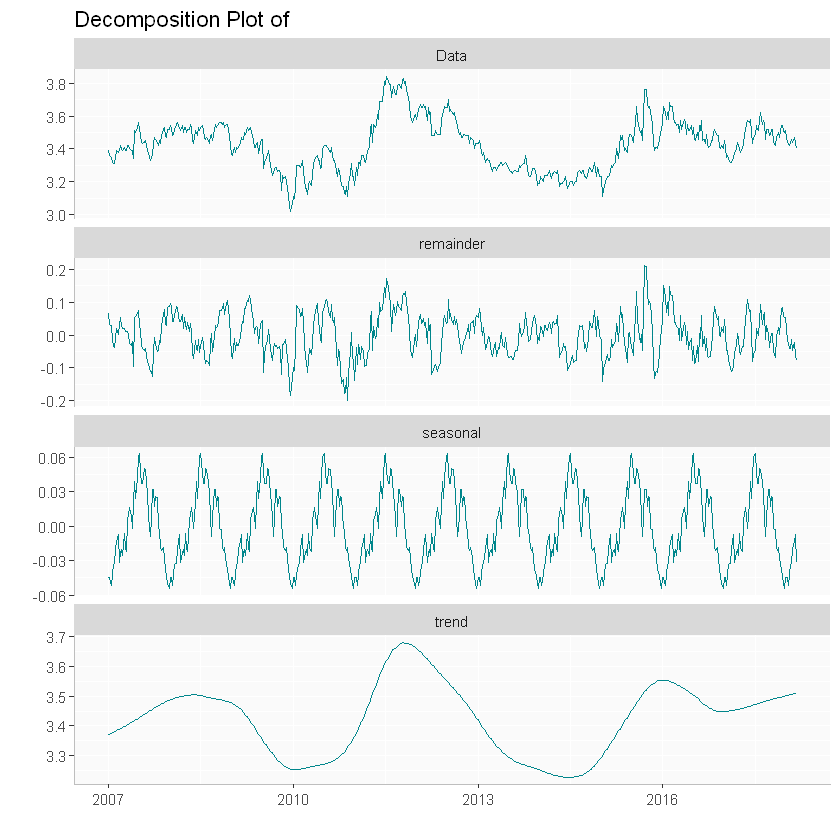

In [24]:
dat_stl <- plot_decomp(dat_training.ts, '')
dat_stl

### Autocorrelation analysis
The geometric decay of the ACF tells us we need to difference, confirming the result from the ADF test above

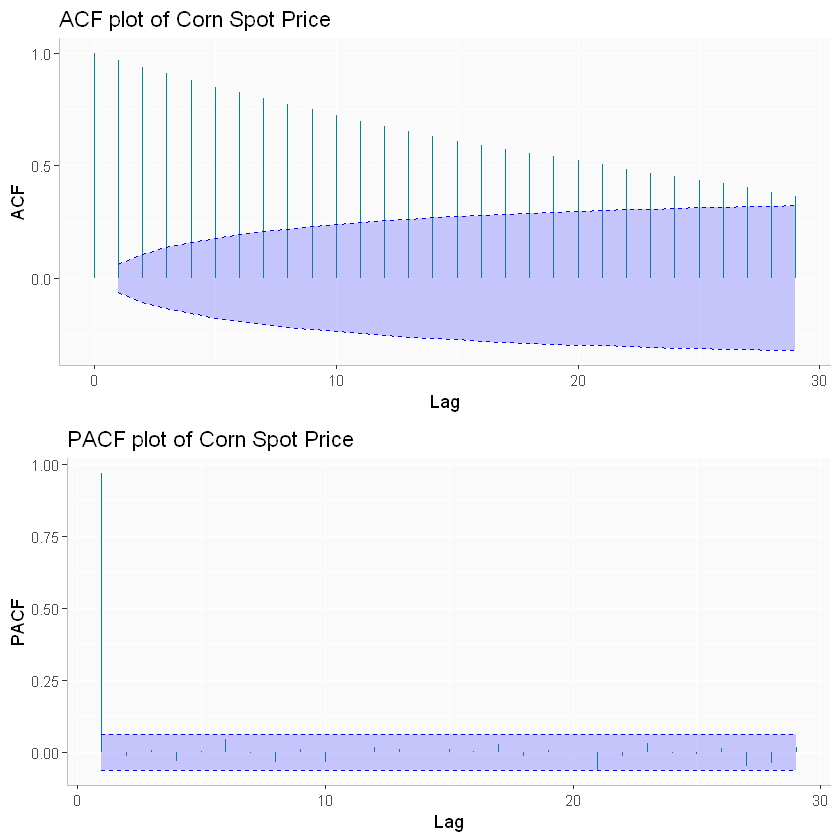

In [25]:
plot_acf_pacf(dat.ts, name)

### Use auto.arima to identify optimal p, d, q parameters for the model
auto.arima() recommends p = 0, d = 1, and q = 0. With p = 0 and q = 0, the model is simply I(0), or a random walk/drift model. This makes sense given that trend is by far the largest component of our decomposition.

In [26]:
auto.arima(dat.ts)

Series: dat.ts 
ARIMA(0,1,0) 

sigma^2 estimated as 0.002221:  log likelihood=1570.63
AIC=-3139.25   AICc=-3139.25   BIC=-3134.38

### Plot the differenced data
The plot of the differenced data looks stationary. Next we will build the model and then run diagnostics on the residuals.

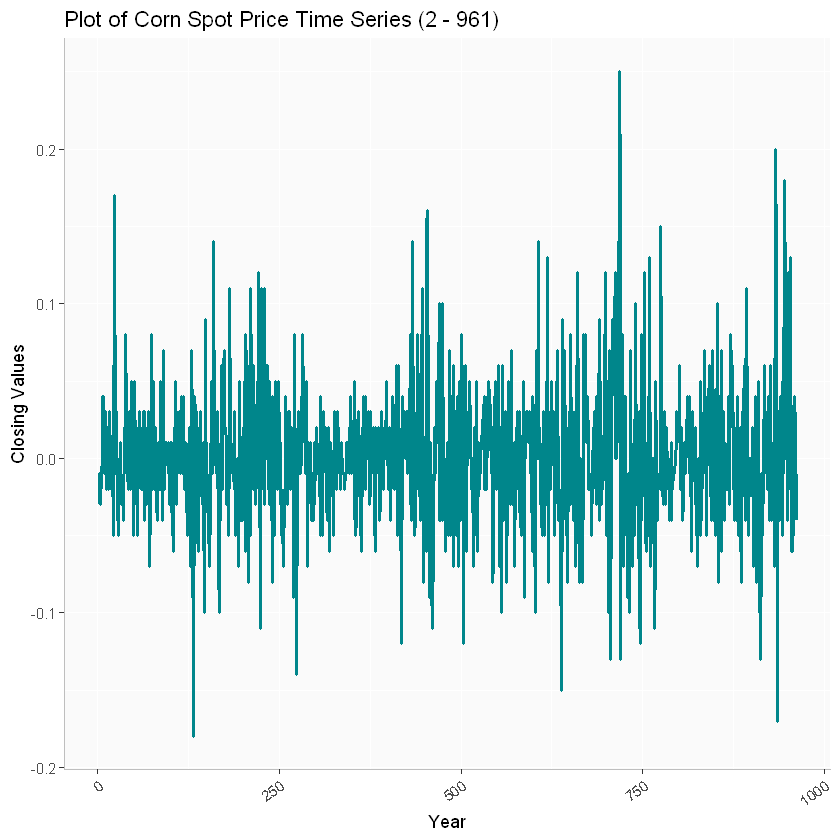

In [27]:
plot_time_series(diff(dat.ts), name)

### Building the model(s)
The model is build with and without precipitation as an explanatory regressor. Adding precipitation to our model actually makes the model very slightly worse, but is nearly the same (AIC = -1816.99 without xreg, -1815.84 with xreg). With better feature engineering and selection we may be able to improve the model with a regressor!

In [28]:
# Build the Model without explanatory regressor
arima_order <- c(0, 1, 0) #from auto.arima
fit <- Arima(dat_training.ts, order = arima_order, include.drift = TRUE)
summary(fit)

Series: dat_training.ts 
ARIMA(0,1,0) with drift 

Coefficients:
       drift
      0.0000
s.e.  0.0017

sigma^2 estimated as 0.001735:  log likelihood=1022.79
AIC=-2041.58   AICc=-2041.56   BIC=-2032.85

Training set error measures:
                      ME      RMSE        MAE          MPE      MAPE      MASE
Training set 5.82471e-06 0.0415778 0.03060965 -0.007169196 0.8930652 0.1752146
                    ACF1
Training set -0.05804862


In [29]:
#The model with explanatory regressor
fit <- Arima(dat_training.ts, order = arima_order, xreg = xreg_training.ts, include.drift = TRUE)
summary(fit)

Series: dat_training.ts 
Regression with ARIMA(0,1,0) errors 

Coefficients:
       drift     xreg
      0.0000  -0.0047
s.e.  0.0017   0.0048

sigma^2 estimated as 0.001735:  log likelihood=1023.28
AIC=-2040.55   AICc=-2040.51   BIC=-2027.46

Training set error measures:
                       ME       RMSE        MAE          MPE      MAPE
Training set 5.824679e-06 0.04154302 0.03063071 -0.007181344 0.8937696
                  MASE        ACF1
Training set 0.1753351 -0.05923493


### Run residual diagnostics
The residuals appear to have a normal distribution with no autocorrelation after lag of 0, confirming our assumptions about the model are correct. We will continue to the forecasting step.

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


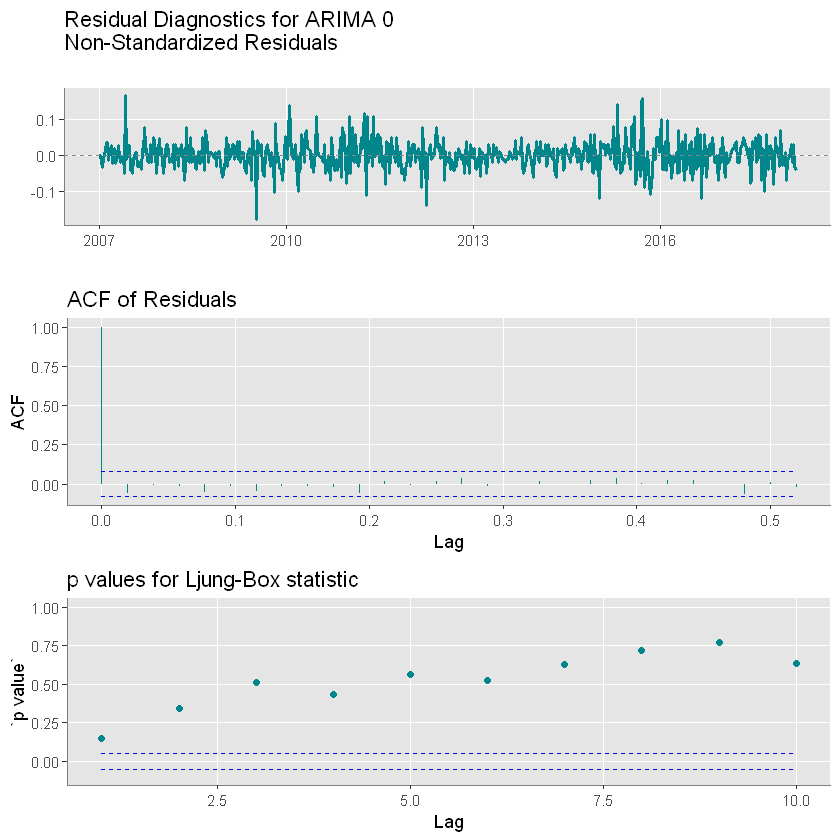

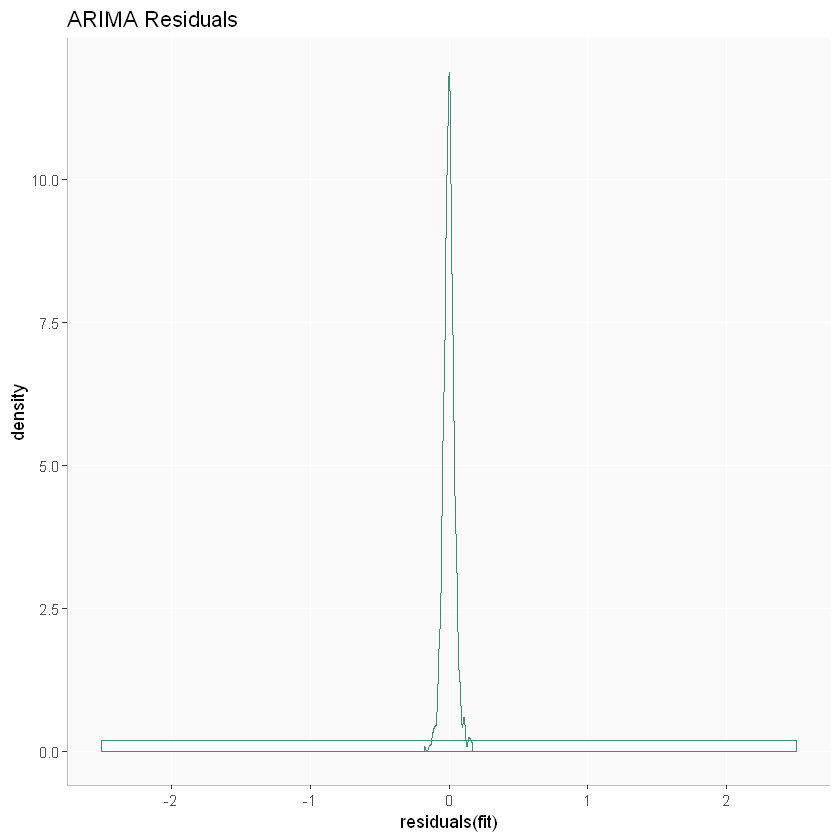

In [30]:
# RESIDUAL DIAGNOSTICS
ggtsdiag_custom(fit, paste("ARIMA", arima_order, sep = ' ')) + 
  theme(panel.background = element_rect(fill = 'gray90'),
        panel.grid.minor = element_blank(),
        axis.line.y = element_line(colour="gray50"),
        axis.line.x = element_line(colour="gray50")) 

residFit <- ggplot(data=fit, aes(residuals(fit))) + 
  geom_histogram(aes(y =..density..),  
                 binwidth = 5,
                 col="aquamarine4", fill="white") +
  geom_density(col="aquamarine4") +
  theme(panel.background = element_rect(fill = "gray98"),
        panel.grid.minor = element_blank(),
        axis.line   = element_line(colour="gray"),
        axis.line.x = element_line(colour="gray")) +
  ggtitle("ARIMA Residuals") 

residFit

## Forecast

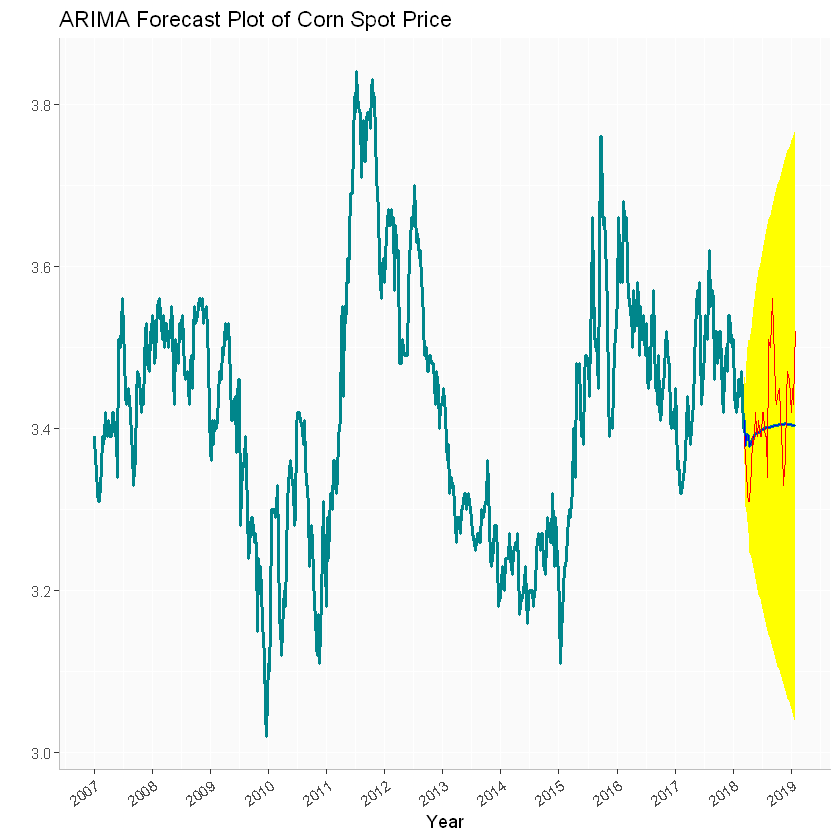

In [32]:
fit <- Arima(dat_training.ts, xreg = xreg_training.ts, order = arima_order, include.drift = TRUE)
fit_arima <- forecast(fit, xreg = xreg_test.ts, h = h)

forecast <- autoplot(fit_arima, 
                     holdout = dat_test.ts,
                     xreg = xreg_test.ts,
                     forc_name = 'ARIMA', 
                     ts_object_name = name)

forecast

### Forecasting the future
What does our model tell us to expect from the next few months? Corn price will trend higher!

Warning message:
"Removed 56 rows containing missing values (geom_path)."

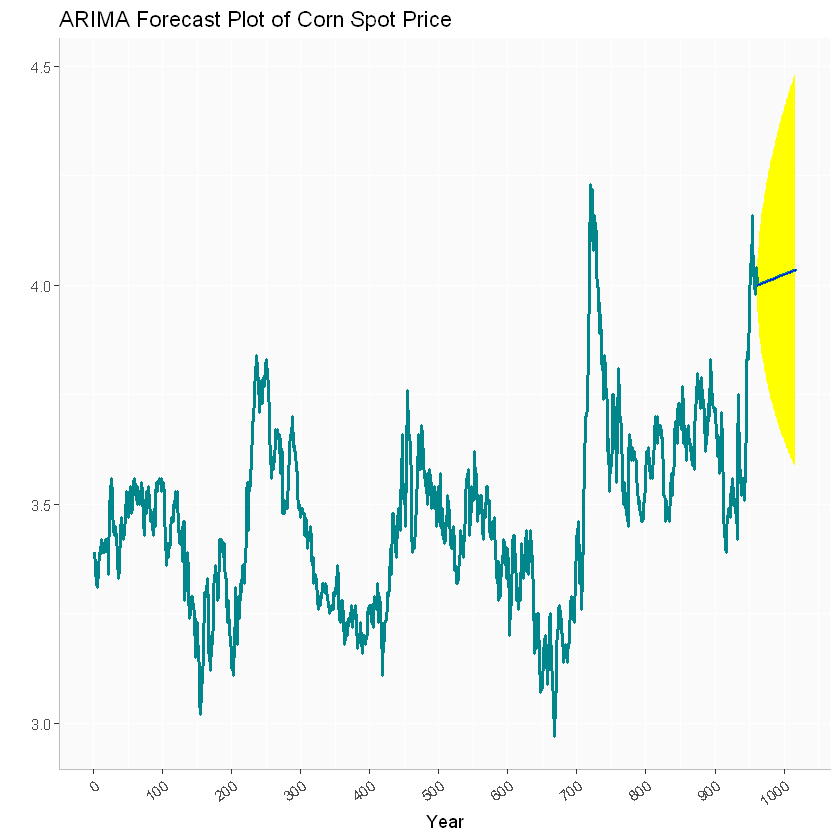

In [19]:
#fit <- Arima(dat_training.ts, order = arima_order, xreg = xreg_training.ts, include.drift = TRUE)
#fit <- Arima(dat.ts, order = arima_order, xreg = xreg.ts, include.drift = T)
#fit_arima <- forecast(fit, xreg = xreg_test.ts, h = h)

fit <- Arima(dat.ts, order = arima_order, include.drift = T)
fit_arima <- forecast(fit, h = h)

forecast <- autoplot(fit_arima,
                     xreg = xreg.ts,
                     forc_name = 'ARIMA', 
                     ts_object_name = name)

forecast